This tutorial demonstrates how to use `cryojax` to build a scattering potential from a PDB entry. Specifically, the tutorial will build a voxel grid, take some steps to validate it, then save the result to be used in subsequent tutorials.

The scattering potential will be built using the tabulation of atomic scattering factors from the work of Lian-Mao Peng, which fits the potential from single atoms to a sum of five gaussians. See the `cryojax` documentation [here](https://mjo22.github.io/cryojax/api/simulator/scattering_potential/#atom-based-scattering-potentials) for more information.

*References:*

- Peng, L-M., et al. "Robust parameterization of elastic and absorptive electron atomic scattering factors." Acta Crystallographica Section A: Foundations of Crystallography 52.2 (1996): 257-276.
- Himes, Benjamin, and Nikolaus Grigorieff. "Cryo-TEM simulations of amorphous radiation-sensitive samples using multislice wave propagation." IUCrJ 8.6 (2021): 943-953.

In [1]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

First, load the atomic positions and identities from a PDB entry. Here, a structure of GroEL (PDB ID 5w0s) is used. This is loaded into a `PengAtomicPotential` object.

In [2]:
import cryojax.simulator as cxs
from cryojax.constants import (
    get_tabulated_scattering_factor_parameters,
    read_peng_element_scattering_factor_parameter_table,
)
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities = read_atoms_from_pdb(
    "./data/5w0s.pdb",
    center=True,
)
scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
    atom_identities, read_peng_element_scattering_factor_parameter_table()
)
atom_potential = cxs.PengAtomicPotential(
    atom_positions,
    scattering_factor_a=scattering_factor_parameters["a"],
    scattering_factor_b=scattering_factor_parameters["b"],
)
print(atom_potential)

PengAtomicPotential(
  atom_positions=f32[54021,3],
  scattering_factor_a=f32[54021,5],
  scattering_factor_b=f32[54021,5],
  b_factors=None
)


We see above that the `PengAtomicPotential` consists of three fields: the `atom_positions`, `scattering_factor_a`, and `scattering_factor_b`.

- The `atom_positions` are the positions of the atoms in angstroms.
- The `scattering_factor_a`, and `scattering_factor_b` are the parameters $a_i$ and $b_i$ from Peng et al. (1996). 

Optionally, we can also load PDB B-factors into the `b_factors` field after making the function call `cryojax.io.read_atoms_from_pdb(..., get_b_factors=True)`.

Next, we can build the voxel grid representation of the potential.

In [3]:
# Evaluate the potential on a voxel grid
shape = (240, 240, 240)
voxel_size = 1.0
real_voxel_grid = atom_potential.as_real_voxel_grid(
    shape,
    voxel_size,
    batch_size_for_z_planes=1,
)

Now, downsample the voxel array to the desired voxel size. Because the potentials from individual atoms are short-ranged, finite sampling effects can be significant and it is best to first generate a potential at a smaller-than-desired voxel size. 

In [4]:
from cryojax.ndimage import downsample_with_fourier_cropping


downsampling_factor = 3
downsampled_voxel_size = downsampling_factor * voxel_size
downsampled_voxel_grid = downsample_with_fourier_cropping(
    real_voxel_grid, downsampling_factor
)

!!! info
    In, `cryojax`, potentials are built in units of *inverse length squared*,
    $[L]^{-2}$. This rescaled potential is defined to be

    $$U(x, y, z) = \frac{2 m e}{\hbar^2} V(x, y, z),$$

    where $V$ is the electrostatic potential energy, $(x, y, z)$ are positional
    coordinates, $m$ is the electron mass, and $e$ is the electron charge.

    In the following, we will compute projections of the potential, which we will
    define to be

    $$U_z(x, y) = \int_{-\infty}^z dz' \ U(x, y, z'),$$

    where in practice the integration domain is taken to be between $z'$-planes above and below where the potential has sufficiently decayed. In this tutorial, this integral is computed with fourier slice extraction.

Now, let's validate that what we see is reasonable. The first validation step is to compute a few different projections of the potential.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Integrated potential, $U_z(x, y)$'}>)

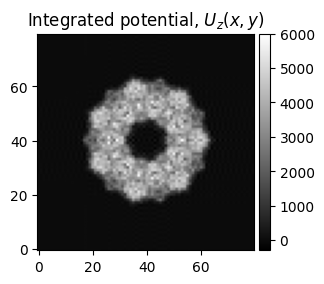

In [5]:
import jax


@jax.jit
def compute_projection(potential):
    """Compute a projection of a voxel-based potential."""
    # ... initialize the integration method for the potential
    integrator = cxs.FourierSliceExtraction()
    # ... and the configuration of the imaging instrument
    config = cxs.BasicConfig(
        shape=potential.shape[0:2],
        pixel_size=potential.voxel_size,
        voltage_in_kilovolts=300.0,
    )
    # ... compute the integrated potential
    integrated_potential = integrator.integrate(
        potential, config, outputs_real_space=True
    )
    return integrated_potential


# Load the voxel grid into a voxel-based potential representation
voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    downsampled_voxel_grid, downsampled_voxel_size
)
# Now, compute the projection integral
integrated_potential = compute_projection(voxel_potential)
# ... and plot
fig, ax = plt.subplots(figsize=(3, 3))
plot_image(integrated_potential, fig, ax, label="Integrated potential, $U_z(x, y)$")

We can also inspect a different viewing angle by rotating the `voxel_potential` to a different pose. This involves instantiating a `cryojax` representation of a pose, which here is the `cryojax.simulator.EulerAnglePose`. The three euler angles in this object are:

- The first euler angle $\phi$, denoted `phi_angle`
- The second euler angle $\theta$, denoted `theta_angle`
- The third euler angle $\psi$, denoted `psi_angle`

The euler angle convention in `cryojax` is a zyz extrinsic rotation, which follows other standard cryo-EM software, such as RELION and cisTEM.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Integrated potential, $U_z(x, y)$'}>)

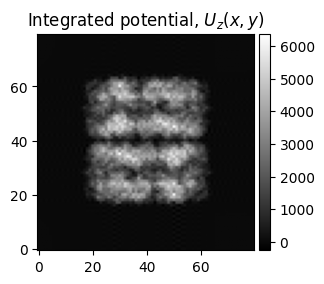

In [6]:
# Instantiate the pose and rotate the potential
# ... angles are in degrees
pose = cxs.EulerAnglePose(phi_angle=0.0, theta_angle=90.0, psi_angle=90.0)
rotated_voxel_potential = voxel_potential.rotate_to_pose(pose)
# ... again compute the projection integral
integrated_potential = compute_projection(rotated_voxel_potential)
# ... and again, plot
fig, ax = plt.subplots(figsize=(3, 3))
plot_image(integrated_potential, fig, ax, label="Integrated potential, $U_z(x, y)$")

Another good sanity check is to check that the potential is relatively weak compared to a typical incident electron beam energy in cryo-EM. For an electron beam with incident wavenumber $k$, this can be checked with the condition

$$U/k^2 << 1,$$

where again $U = 2 m e V / \hbar^2$ is the rescaled potential. Below, we consider an incident energy of $300 \ \textrm{keV}$.

In [7]:
import numpy as np

from cryojax.constants import convert_keV_to_angstroms


# First compute the wavenumber
voltage_in_kilovolts = 300.0
wavelength_in_angstroms = convert_keV_to_angstroms(voltage_in_kilovolts)
wavenumber = 2 * np.pi / wavelength_in_angstroms
# ... now get the maximum value of the potential
potential_maximum = downsampled_voxel_grid.max()
# ... and compare
print(potential_maximum / wavenumber**2)

0.0013620262


Looks reasonable! Finally, we can write the voxel grid to disk for later processing.

In [8]:
# from cryojax.io import write_volume_to_mrc


# write_volume_to_mrc(
#     downsampled_voxel_grid,
#     downsampled_voxel_size,
#     "./data/groel_5w0s_scattering_potential.mrc",
#     overwrite=True,
# )